In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sunxin/minico

1.13.2
2.2.4


Using TensorFlow backend.


In [2]:
import numpy as np
from keras.datasets import mnist
from keras import models
from keras import layers
import keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def convresblock(x, nfeats=8, ksize=3, nskipped=2, elu=True):
    """The proposed residual block from [4].

    Running with elu=True will use ELU nonlinearity and running with
    elu=False will use BatchNorm + RELU nonlinearity.  While ELU's are fast
    due to the fact they do not suffer from BatchNorm overhead, they may
    overfit because they do not offer the stochastic element of the batch
    formation process of BatchNorm, which acts as a good regularizer.

    # Arguments
        x: 4D tensor, the tensor to feed through the block
        nfeats: Integer, number of feature maps for conv layers.
        ksize: Integer, width and height of conv kernels in first convolution.
        nskipped: Integer, number of conv layers for the residual function.
        elu: Boolean, whether to use ELU or BN+RELU.

    # Input shape
        4D tensor with shape:
        `(batch, channels, rows, cols)`

    # Output shape
        4D tensor with shape:
        `(batch, filters, rows, cols)`
    """
    y0 = layers.Conv2D(nfeats, ksize, padding='same')(x)
    y = y0
    for i in range(nskipped):
        if elu:
            y = layers.ELU()(y)
        else:
            y = layers.BatchNormalization(axis=1)(y)
            y = layers.Activation('relu')(y)
        y = layers.Conv2D(nfeats, 1, padding='same')(y)
    return layers.add([y0, y])

In [4]:
def getwhere(x):
    ''' Calculate the 'where' mask that contains switches indicating which
    index contained the max value when MaxPool2D was applied.  Using the
    gradient of the sum is a nice trick to keep everything high level.'''
    y_prepool, y_postpool = x
    return K.gradients(K.sum(y_postpool), y_prepool)

In [5]:
# This example assume 'channels_first' data format.
K.set_image_data_format('channels_first')

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples


In [6]:
# The size of the kernel used for the MaxPooling2D
pool_size = 2
# The total number of feature maps at each layer
nfeats = [8, 16, 32, 64, 128]
# The sizes of the pooling kernel at each layer
pool_sizes = np.array([1, 1, 1, 1, 1]) * pool_size
# The convolution kernel size
ksize = 3
# Number of epochs to train for
epochs = 5
# Batch size during training
batch_size = 128

if pool_size == 2:
    # if using a 5 layer net of pool_size = 2
    x_train = np.pad(x_train, [[0, 0], [0, 0], [2, 2], [2, 2]],
                     mode='constant')
    x_test = np.pad(x_test, [[0, 0], [0, 0], [2, 2], [2, 2]], mode='constant')
    nlayers = 5
# elif pool_size == 3:
#     # if using a 3 layer net of pool_size = 3
#     x_train = x_train[:, :, :-1, :-1]
#     x_test = x_test[:, :, :-1, :-1]
#     nlayers = 3
# else:
#     import sys
#     sys.exit('Script supports pool_size of 2 and 3.')

In [7]:
# Shape of input to train on (note that model is fully convolutional however)
input_shape = x_train.shape[1:]
# The final list of the size of axis=1 for all layers, including input
nfeats_all = [input_shape[0]] + nfeats

# First build the encoder, all the while keeping track of the 'where' masks
img_input = layers.Input(shape=input_shape)

# We push the 'where' masks to the following list
wheres = [None] * nlayers
y = img_input
for i in range(nlayers):
    y_prepool = convresblock(y, nfeats=nfeats_all[i + 1], ksize=ksize)
    y = layers.MaxPooling2D(pool_size=(pool_sizes[i], pool_sizes[i]))(y_prepool)
    wheres[i] = layers.Lambda(
        getwhere, output_shape=lambda x: x[0])([y_prepool, y])

# Now build the decoder, and use the stored 'where' masks to place the features
for i in range(nlayers):
    ind = nlayers - 1 - i
    y = layers.UpSampling2D(size=(pool_sizes[ind], pool_sizes[ind]))(y)
    y = layers.multiply([y, wheres[ind]])
    y = convresblock(y, nfeats=nfeats_all[ind], ksize=ksize)

# Use hard_simgoid to clip range of reconstruction
y = layers.Activation('hard_sigmoid')(y)

# Define the model and it's mean square error loss, and compile it with Adam
model = models.Model(img_input, y)
model.compile('adam', 'mse')

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
# Fit the model
model.fit(x_train, x_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, x_test))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 12s 200us/step - loss: 0.0221 - val_loss: 0.0060
Epoch 2/5
60000/60000 [==============================] - 9s 158us/step - loss: 0.0046 - val_loss: 0.0037
Epoch 3/5
60000/60000 [==============================] - 10s 159us/step - loss: 0.0033 - val_loss: 0.0029
Epoch 4/5
60000/60000 [==============================] - 10s 159us/step - loss: 0.0028 - val_loss: 0.0026
Epoch 5/5
60000/60000 [==============================] - 10s 159us/step - loss: 0.0025 - val_loss: 0.0023


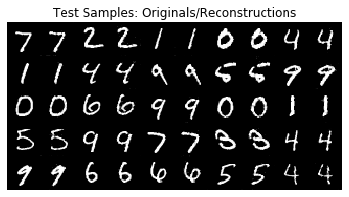

In [9]:
# Plot
x_recon = model.predict(x_test[:25])
x_plot = np.concatenate((x_test[:25], x_recon), axis=1)
x_plot = x_plot.reshape((5, 10, input_shape[-2], input_shape[-1]))
x_plot = np.vstack([np.hstack(x) for x in x_plot])
plt.figure()
plt.axis('off')
plt.title('Test Samples: Originals/Reconstructions')
plt.imshow(x_plot, interpolation='none', cmap='gray')
plt.savefig('reconstructions.png')